## Lab 2 Question Answering system on SberQuAD dataset

In this lab assignment we'll train Question Answering system for Russian language on SbeQuAD dataset.  
Then we'll evaluate the quality on validation data in terms of F1 and Exact match (EM) metrics.  
We'll use RuBERT pretrained language model by DeepPavlov. Two linear layers are added on the top of the RuBERT to solve Question Answering task.

Import required libraries and own modules

In [2]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6, 7"
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from transformers import logging
logging.set_verbosity_error()

%matplotlib inline

import util
from models import RUBertForQA

Read raw SberQuAD data, enrich and tokenize it, get train and valid datasets.

In [3]:
model_name = "DeepPavlov/rubert-base-cased"
# create train and valid data  in appropriate formats from SberQuad files
train_context, train_question, train_answer, train_question_context = (
    util.read_squad('data/train-v1.1.json'))
valid_context, valid_question, valid_answer, valid_question_context = (
    util.read_squad('data/dev-v1.1.json'))

# add index of end position of the answer
util.add_end_idx(train_answer, train_context)
util.add_end_idx(valid_answer, valid_context)

# define lists with text values
train_context_text = [train_context[context_id] for context_id in train_question_context.values()]
valid_context_text = [valid_context[context_id] for context_id in valid_question_context.values()]

train_question_text = list(train_question.values())
valid_question_text = list(valid_question.values())

# define lists with ids
valid_context_id = list(valid_question_context.values())
valid_question_id = list(valid_question_context.keys())

# get tokenized encodings
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_encoding = (tokenizer(train_context_text, train_question_text, 
                             truncation=True, padding=True, max_length = max_length, return_tensors = 'pt'))
valid_encoding = (tokenizer(valid_context_text, valid_question_text, 
                             truncation=True, padding=True, max_length = max_length, return_tensors = 'pt'))

# enrich train and valid encodings: add fields 'start_positions', 'end_positions' and 'ids':
# 'start_positions' - token number where the answer starts, 'end_positions' - where the answer ends
# 'ids' - id of the question in SberQuad dataset
train_truncated_idx = util.add_token_positions(train_encoding, train_answer, max_length)
valid_truncated_idx = util.add_token_positions(valid_encoding, valid_answer, max_length)

#create Dataset objects from encodings
train_dataset = util.SquadDataset(train_encoding)
valid_dataset = util.SquadDataset(valid_encoding)

/home/naanvorobeva/miniconda3/envs/python3.7/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


Need to note. Function `add_token_positions` not only updates encodings, but also returns `truncated_idxs`.  
We set `max_length = 512` - max token number in sequence 'CLS + context + SEP + question'. 512 is set to fit tokenized encodings to bert-based model.  If any sequence in dataset is greater than 512 tokens, the context is truncated. The answer might be in truncated part, and such sequences are useless for training process. `truncated_idxs` returns list of ids of these examples. 
Take a look how many such examples we have in comparison with total training and valid datasets. 

In [4]:
print('Total number of training examples:', len(train_encoding['input_ids']))
print('Total number of valid examples:', len(valid_encoding['input_ids']))
print('Number of training examples with truncated answer:', len(train_truncated_idx))
print('Number of valid examples with truncated answer:', len(valid_truncated_idx))

Total number of training examples: 45328
Total number of valid examples: 5036
Number of training examples with truncated answer: 12
Number of valid examples with truncated answer: 0


Well, there are only 12 examples in training set. We could remove them, but experiments shows that it doesn't increase the quality in terms of loss and F1/EM metrics.  

Look how many examples with UNK token there are in valid dataset. It's important because we need to reconstruct text answer during validation to compute F1 and EM metrics. If there are UNK tokens, we can't directly convert tokens to string to get the answer. Text answer will contain UNK in this case and won't be equal to original text answer.

In [5]:
unk_token = tokenizer.unk_token
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
num_unk_seq = torch.unique(torch.where(valid_encoding['input_ids'] == unk_token_idx)[0])
print('Number of examples with UNK token in valid dataset:', num_unk_seq.shape[0])

Number of examples with UNK token in valid dataset: 53


To make F1/EM calculation fair, we'll use predicted start and end tokens to get start and end characters in original context. We'll construct text answer as `valid_context[start_char:end_char]`. In this case we wont't get UNK string in text answer.

Define model, loss, loaders and optimizer.

In [6]:
pad_token = tokenizer.pad_token
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)

BATCH_SIZE = 24
DROPOUT = 0.5
LEARNING_RATE = 5e-5
bert = AutoModel.from_pretrained(model_name, num_hidden_layers = 9)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = RUBertForQA(bert, DROPOUT)
model = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.NLLLoss(ignore_index = pad_token_idx)
criterion = criterion.cuda()

Run training process

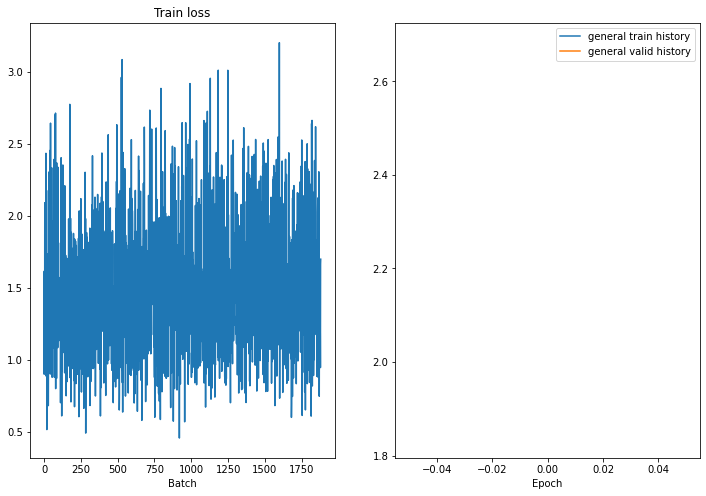

1889it [16:00,  1.97it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:51<00:00,  4.09it/s]

Epoch: 02 | Time: 16m 51s
	Train Loss: 1.476
	 Val. Loss: 1.863


In [7]:
N_EPOCHS = 2
train_history = []
valid_history = []
path_to_dict = 'model_rubert_fin_ts.pt'
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):

        start_time = time.time()
        train_loss = util.train(model, train_loader, optimizer, criterion,
                           train_history, valid_history)
        _, _, valid_loss = util.get_logits(model, valid_loader, get_loss=True, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = util.epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_to_dict)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')

Take a look at model parameters

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of model trainable parameters:', count_parameters(model))

Number of model trainable parameters: 156591362


Load model with the best valid loss

In [7]:
path_to_dict = '../model checkpoints/QA_best.pt'
model_load = RUBertForQA(bert, DROPOUT)
model_load = torch.nn.DataParallel(model_load, device_ids=[0, 1]).cuda()
model_load.load_state_dict(torch.load(path_to_dict))

<All keys matched successfully>

Finally, evaluate the quality

In [8]:
valid_logp_start, valid_logp_end, valid_loss = util.get_logits(model_load, valid_loader, get_loss=True, criterion)
valid_pred_answer, _ = util.get_answer(valid_logp_start, valid_logp_end, 
    valid_context_text, valid_context_id, valid_question_id, valid_encoding)
valid_metrics = util.eval_dicts(valid_answer, valid_pred_answer, False)
print('NLL:', valid_loss)
print(valid_metrics)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:52<00:00,  4.02it/s]


NLL: 1.8037955734443816
{'F1': 82.32876378337289, 'EM': 63.185067513899924}


 Well, our results look fine.  
  
  Also let's add 10 random examples in Tensorboaad at './save/visualize'. Format is the following:  
  - Question
  - Context
  - Answer
  - Prediction

In [9]:
# write random examples of context, question, true and predicted answers to TensorBoard
tbx = SummaryWriter('./save/visualize')
util.visualize(tbx,
            preds=valid_pred_answer,
            answers=valid_answer,
            contexts=valid_context,
            questions=valid_question,
            question_context=valid_question_context,
            step=0,
            split='dev',
            num_visuals=10)

### Conclusion  
We trained Question Answering system on SberQuad dataset for Russian language.  The core of the model is pretrained RuBERT language model based on transformer approach.  
Training time is just about 30 minutes on 2 Nvidia GeForce RTX 2080 GPUs. 2 epoches are enough to surpass baseline approach based on BiDAF model.  
Our results are:  
NLL: 1.80  
F1: 82.33  
EM: 63.19  
Approximate results for baseline BiDAF model:  
NLL: 02.47  
F1: 75.62  
EM: 55.73